##Big Data Project: Twitter Sentiment Prediction
liangyuwang

## Mounting the buckets

In [ ]:
from pyspark.sql import SparkSession
spark=SparkSession \
        .builder \
        .appName('Twitter Sentiment Analysis') \
        .getOrCreate()
print('Session Created')

sc=spark.sparkContext

Session Created


In [ ]:
def mount_s3_bucket(access_key, secret_key, bucket_name, mount_folder):
  ACCESS_KEY_ID = access_key
  SECRET_ACCESS_KEY = secret_key
  ENCODED_SECRET_KEY = SECRET_ACCESS_KEY.replace("/", "%2F")

  print ("Mounting", bucket_name)

  try:
    # Unmount the data in case it was already mounted.
    dbutils.fs.unmount("/mnt/%s" % mount_folder)
    
  except:
    # If it fails to unmount it most likely wasn't mounted in the first place
    print ("Directory not unmounted: ", mount_folder)
    
  finally:
    # Lastly, mount our bucket.
    dbutils.fs.mount("s3a://%s:%s@%s" % (ACCESS_KEY_ID, ENCODED_SECRET_KEY, bucket_name), "/mnt/%s" % mount_folder)
    #dbutils.fs.mount("s3a://"+ ACCESS_KEY_ID + ":" + ENCODED_SECRET_KEY + "@" + bucket_name, mount_folder)
    print ("The bucket", bucket_name, "was mounted to", mount_folder, "\n")


# Set AWS programmatic access credentials
ACCESS_KEY = " "
SECRET_ACCESS_KEY = " "


mount_s3_bucket(ACCESS_KEY, SECRET_ACCESS_KEY, "weclouddata/twitter/", "twitter_sentiment_dataset")



Mounting weclouddata/twitter/
/mnt/twitter_sentiment_dataset has been unmounted.
The bucket weclouddata/twitter/ was mounted to twitter_sentiment_dataset 



In [ ]:
%fs ls /mnt/twitter_sentiment_dataset/

path,name,size,modificationTime
dbfs:/mnt/twitter_sentiment_dataset/AI/,AI/,0,0
dbfs:/mnt/twitter_sentiment_dataset/BlackFriday/,BlackFriday/,0,0
dbfs:/mnt/twitter_sentiment_dataset/CSIS/,CSIS/,0,0
dbfs:/mnt/twitter_sentiment_dataset/Do Not Use/,Do Not Use/,0,0
dbfs:/mnt/twitter_sentiment_dataset/ElonMusk/,ElonMusk/,0,0
dbfs:/mnt/twitter_sentiment_dataset/Inflation/,Inflation/,0,0
dbfs:/mnt/twitter_sentiment_dataset/Iran/,Iran/,0,0
dbfs:/mnt/twitter_sentiment_dataset/MTA/,MTA/,0,0
dbfs:/mnt/twitter_sentiment_dataset/WorldCup/,WorldCup/,0,0
dbfs:/mnt/twitter_sentiment_dataset/cancer/,cancer/,0,0


## Creating the Dataframe

In [ ]:
# Read CDR data into a DF
tweetFile = '/mnt/twitter_sentiment_dataset/AI/*/*/*/*/*'

from pyspark.sql.types import StructType, StructField, IntegerType, StringType

tweetSchema = StructType([
    StructField("id", StringType(), True),
    StructField("name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("tweet", StringType(), True),
    StructField("followers_count", IntegerType(), True),
    StructField("location", StringType(), True),
    StructField("geo", StringType(), True),
    StructField("created_at", StringType(), True)]
)

twt = (spark.read
    .option("header", "false")
    .option("delimiter", "\t")
    .schema(tweetSchema)
    .csv(tweetFile)
)

In [ ]:
twt.cache()
twt.count()

Out[5]: 10497

In [ ]:
twt.rdd.getNumPartitions()

Out[6]: 10

In [ ]:
twt=twt.coalesce(10)
display(twt.count())

10497

In [ ]:
display(twt.rdd.getNumPartitions())

10

In [ ]:

twt.show(20)

+-------------------+-------------+--------------+--------------------+---------------+--------------------+----+--------------------+
|                 id|         name|      username|               tweet|followers_count|            location| geo|          created_at|
+-------------------+-------------+--------------+--------------------+---------------+--------------------+----+--------------------+
|1601172099045158912| YUNUS HANBAL|   HanbalYunus|@CryptoEmdarks Th...|             21|                None|None|Fri Dec 09 11:09:...|
|1601172122730041344|  ASLI HANBAL|    HanbalAsli|@Crypto__Diva #GP...|            152|                None|None|Fri Dec 09 11:09:...|
|1601172161372491778| YUNUS HANBAL|   HanbalYunus|@CryptoThro There...|             21|                None|None|Fri Dec 09 11:09:...|
|1601172171602419712|  ASLI HANBAL|    HanbalAsli|@belufrancese #GP...|            152|                None|None|Fri Dec 09 11:09:...|
|1601172214056767489| YUNUS HANBAL|   HanbalYunus|@cryp

In [ ]:

display(twt)

## Clean the dataframe and creating sentiment/label column


In [ ]:
#tweet text cleaning

from pyspark.sql import functions as F
from pyspark.sql.functions import col, trim

#remove non-alphabet characters, trim epmpty space and urls
twt_clean = twt.withColumn('tweet', F.regexp_replace('tweet', r"http\S+", "")) \
                     .withColumn('tweet', F.regexp_replace('tweet', r"[^a-zA-Z]", " ")) \
                     .withColumn('tweet', F.regexp_replace('tweet', r"\s+", " ")) \
                     .withColumn('tweet', F.lower('tweet')) \
                     .withColumn('tweet', F.trim('tweet'))

#drop rows with empty tweet
twt_clean = twt_clean.filter(trim(col("tweet")) != "")

display(twt_clean)

In [ ]:
twt_clean.count()

Out[12]: 10491

In [ ]:
#add sentiment labels column using VADER

!pip install nltk
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.functions import col
import pandas as pd

sia = SentimentIntensityAnalyzer()

@pandas_udf(IntegerType())
def analyze_sentiment(column: pd.Series) -> pd.Series:
    return column.apply(lambda text: 2 if sia.polarity_scores(text)['compound'] > 0.05 else (0 if sia.polarity_scores(text)['compound'] < -0.05 else 1))

twt_labeled = twt_clean.withColumn("label", analyze_sentiment(col('tweet')))

  Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
  Using cached tqdm-4.66.1-py3-none-any.whl (78 kB)
  Using cached regex-2023.12.25-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-b85b72ca-1db4-4894-9ae0-cde33dd9a8f0/bin/python -m pip install --upgrade pip' command.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
twt_labeled.show(30)

+-------------------+--------------------+---------------+--------------------+---------------+--------------------+----+--------------------+-----+
|                 id|                name|       username|               tweet|followers_count|            location| geo|          created_at|label|
+-------------------+--------------------+---------------+--------------------+---------------+--------------------+----+--------------------+-----+
|1601172099045158912|        YUNUS HANBAL|    HanbalYunus|cryptoemdarks the...|             21|                None|None|Fri Dec 09 11:09:...|    2|
|1601172122730041344|         ASLI HANBAL|     HanbalAsli|crypto diva gplex...|            152|                None|None|Fri Dec 09 11:09:...|    1|
|1601172161372491778|        YUNUS HANBAL|    HanbalYunus|cryptothro there ...|             21|                None|None|Fri Dec 09 11:09:...|    2|
|1601172171602419712|         ASLI HANBAL|     HanbalAsli|belufrancese gple...|            152|           

## Exploratory Data Analysis

In [ ]:
# Exploratory data analysis

twt_labeled.describe().toPandas()

,summary,id,name,username,tweet,followers_count,location,geo,created_at,label
0,count,10491,10491,10491,10491,10462,10462,10457,10457,10491
1,mean,1.60110676453357568E18,30871.0,2.00006535E7,None,19069.50420569681,1.5948963317385805E27,None,None,1.6218663616433133
2,stddev,1.1148630341787806E14,61723.33420460477,2.828476692931551E7,None,542408.9315508209,3.784185097300114E27,None,None,0.6851929690440218
3,min,1600919229729067008,! .🌟| 2🅿🅰🅲🅺 🌟 | The RoyaLand,01101101UTE,a bigram poem inspired by tdavelife artificial...,0,,None,Fri Dec 09 00:00:00 +0000 2022,0
4,max,1601279556933107713,🫧🌌☃️Platoni🇺🇦🏳️‍🌈#Укртві (217/320) #TWD,zvicpa,zoe jimenez is a second life creator and photo...,39130625,🪐,"{'type': 'Point', 'coordinates': [41.8752, -88...",Thu Dec 08 23:59:40 +0000 2022,2


In [ ]:
#count the size of each sentiment class

val_counts= twt_labeled.groupBy( col("label").alias("sentiment") ).count()

display(val_counts)


sentiment,count
1,1509
2,7753
0,1229


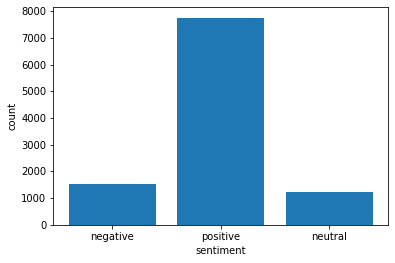

In [ ]:
import matplotlib.pyplot as plt

cat = ['negative','positive','neutral']
y=[v['count'] for v in val_counts.select('count').collect()]
plt.bar(cat, y)
plt.ylabel('count')
plt.xlabel('sentiment')

plt.show()

In [ ]:
#show missing values count for each column

from pyspark.sql.functions import count, when, isnan, first

display( twt_labeled.select([count(when(isnan(col(c)) | col(c).isNull() | (col(c) == "None"), c)).alias(c) for c in twt_labeled.columns]))


id,name,username,tweet,followers_count,location,geo,created_at,label
0,0,0,0,29,4229,10488,34,0


In [ ]:
#display the username with the highest number of tweets

max_tweets = twt_labeled.groupBy("username").agg(count("tweet").alias("tweet_count")).orderBy(col("tweet_count").desc()).limit(5)
max_tweets.show()

+---------------+-----------+
|       username|tweet_count|
+---------------+-----------+
|      ozgungrbz|        227|
| JagdipSanghera|         90|
|ricardo_ik_ahau|         88|
|         ide747|         76|
|    AISelection|         66|
+---------------+-----------+



In [ ]:
#display the username with the highest follower counts
#we see that most popular accounts are news companies

max_followers = (twt_labeled.groupBy("username")
                              .max("followers_count")
                              .withColumnRenamed("max(followers_count)", "max_followers")
                              .orderBy(col("max_followers").desc())
                              .limit(10))
max_followers.show()

+---------------+-------------+
|       username|max_followers|
+---------------+-------------+
|       BBCWorld|     39130625|
|            WSJ|     20379149|
|         Forbes|     18581160|
|      johngreen|      4650512|
|     ChinaDaily|      4193132|
|  airnewsalerts|      3139439|
| engineers_feed|      2606716|
|FortuneMagazine|      2357647|
|moneycontrolcom|      1354796|
|       edutopia|      1237782|
+---------------+-------------+



In [ ]:
#show the most common tweet locations

top_locations = (twt_labeled.groupBy("location")
                  .agg(count("location").alias("count"))
                  .orderBy(col("count").desc())
                  .limit(10))

top_locations.show()

+-----------------+-----+
|         location|count|
+-----------------+-----+
|             None| 4200|
|    United States|  128|
|   United Kingdom|  118|
|San Francisco, CA|  108|
|    Benito Juárez|   88|
|           Global|   84|
|            World|   67|
|       London, UK|   64|
|            India|   62|
|  London, England|   48|
+-----------------+-----+



In [ ]:
#show the most common geo

top_geo = (twt_labeled.groupBy("geo")
                  .agg(count("geo").alias("count"))
                  .orderBy(col("count").desc())
                  .limit(5))

top_geo.show()

+--------------------+-----+
|                 geo|count|
+--------------------+-----+
|                None|10454|
|{'type': 'Point',...|    1|
|{'type': 'Point',...|    1|
|{'type': 'Point',...|    1|
|                null|    0|
+--------------------+-----+



In [ ]:
#show tweets by day of the week

from pyspark.sql.functions import split

days_count=twt_labeled.groupBy( (split(col("created_at"), " ")[0]).alias("day")).agg(count("*").alias("count"))
days_count = days_count.na.drop()
days_count.show(10)


+---+-----+
|day|count|
+---+-----+
|Thu| 2680|
|Fri| 7777|
+---+-----+



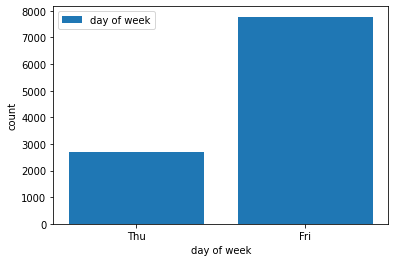

In [ ]:
#most tweets are made on friday

cat = [v['day'] for v in days_count.select("day").collect()]
y= [v['count'] for v in days_count.select("count").collect()]
plt.bar(cat, y)
plt.ylabel('count')
plt.xlabel('day of week')
plt.legend(['day of week'], loc='upper left')

plt.show()

In [ ]:
retweets = twt_labeled.filter(col("tweet").startswith("rt "))
retweets_count = retweets.count()
tweets_count=twt_labeled.count()
print(retweets_count, '\n')
print((retweets_count/tweets_count)*100)

#59% of tweets are retweets

6165 

58.76465541893051


## Machine Learning

In [ ]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, HashingTF, IDF, NGram, VectorAssembler, ChiSqSelector
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#use 80% data for training, 20% for testing
train, test = twt_labeled.randomSplit([0.8, 0.2], seed=888)

#create transformers and pipeline
tokenizer= Tokenizer(inputCol="tweet", outputCol="tokens")
stopword_remover=StopWordsRemover(inputCol="tokens", outputCol="filtered")
cv= CountVectorizer(vocabSize=2**16, inputCol="filtered", outputCol="cv")
idf= IDF(inputCol="cv", outputCol="1gram_idf", minDocFreq=5)
ngram= NGram(n=2, inputCol="filtered", outputCol="2gram")
ngram_hashingtf= HashingTF(inputCol="2gram", outputCol="2gram_tf", numFeatures=20000)
ngram_idf= IDF(inputCol="2gram_tf", outputCol="2gram_idf", minDocFreq=5)

assembler =VectorAssembler(inputCols=["1gram_idf", "2gram_idf"], outputCol="rawFeatures")

selector= ChiSqSelector(numTopFeatures=2**14, featuresCol="rawFeatures", outputCol="features")

lr=LogisticRegression(maxIter=100, family="multinomial")
pipeline = Pipeline(stages=[tokenizer, stopword_remover, cv, idf, ngram, ngram_hashingtf, ngram_idf, assembler, selector, lr])


#train logistc regresison model
pipeline_model=pipeline.fit(train)
predictions_lr=pipeline_model.transform(test)


In [ ]:
evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
roc_auc=evaluator.evaluate(predictions_lr)
accuracy = evaluator.evaluate(predictions_lr, {evaluator.metricName: "accuracy"})

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.8977
ROC-AUC: 0.8976


In [ ]:
#train decision tree model
dt= DecisionTreeClassifier()
pipeline = Pipeline(stages=[tokenizer, stopword_remover, cv, idf, ngram, ngram_hashingtf, ngram_idf, assembler, selector, dt])

pipeline_model=pipeline.fit(train)
predictions_dt=pipeline_model.transform(test)


In [ ]:
evaluator=MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
roc_auc=evaluator.evaluate(predictions_dt)
accuracy = evaluator.evaluate(predictions_dt, {evaluator.metricName: "accuracy"})

print("Accuracy Score: {0:.4f}".format(accuracy))
print("ROC-AUC: {0:.4f}".format(roc_auc))

Accuracy Score: 0.7974
ROC-AUC: 0.7426


## Save data to bucket

In [ ]:
#logistic regression is the most accurate model

pipeline = Pipeline(stages=[tokenizer, stopword_remover, cv, idf, ngram, ngram_hashingtf, ngram_idf, assembler, selector, lr])
pipeline_model=pipeline.fit(twt_labeled)
twt_prediction=pipeline_model.transform(twt_clean)

In [ ]:
twt_prediction.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- followers_count: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- geo: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- cv: vector (nullable = true)
 |-- 1gram_idf: vector (nullable = true)
 |-- 2gram: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- 2gram_tf: vector (nullable = true)
 |-- 2gram_idf: vector (nullable = true)
 |-- rawFeatures: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
twt_predictions = twt_prediction.drop('tokens', 'filtered', 'cv', '1gram_idf', '2gram', '2gram_tf', '2gram_idf', 'rawFeatures', 'features', 'rawPrediction', 'probability')

In [ ]:


spark.conf.set("fs.s3n.awsAccessKeyId", ACCESS_KEY)
spark.conf.set("fs.s3n.awsSecretAccessKey", SECRET_ACCESS_KEY)


(twt.write
    .parquet('s3://b19-liangyu-awscli/BigDataProject/raw'))

(twt_labeled.write
    .parquet('s3://b19-liangyu-awscli/BigDataProject/cleaned'))


(twt_predictions.write
    .parquet('s3://b19-liangyu-awscli/BigDataProject/prediction'))
